## Giới thiệu
Trong phần này chúng ta xây dựng mô hình phân loại văn bản sử dụng kiến trúc mạng TextCNN
trên bộ dữ liệu NTC-SCV:

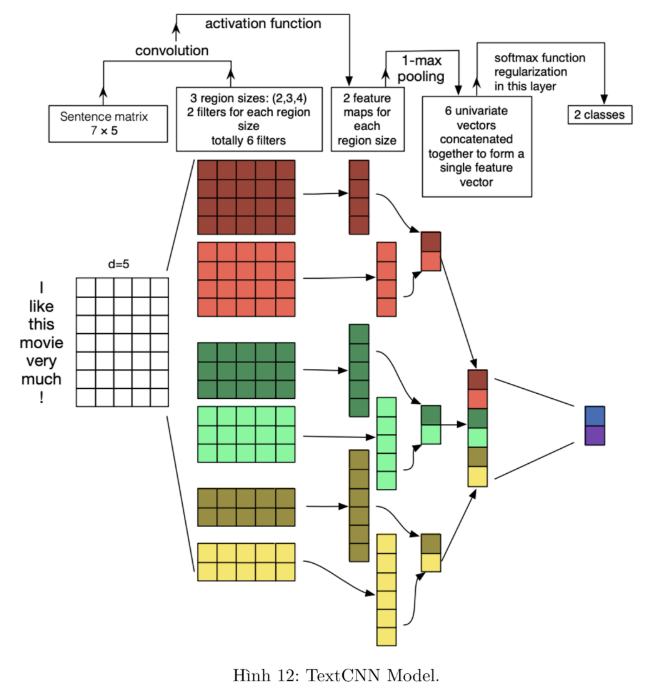

## Import các thư viện cần thiết

In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [2]:
# Install library
!pip install langid
#!pip install torch==2.5.1
!pip install -q torchtext==0.16.0

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

## Tải về bộ dữ liệu:


In [4]:
def load_data_from_path(folder_path):
  examples = []
  for label in os.listdir(folder_path):
    full_path = os.path.join(folder_path, label)
    for file_name in os.listdir(full_path):
      file_path = os.path.join(full_path, file_name)
      with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        sentence = " ".join(lines)
        if label == "neg":
          label = 0
        if label == "pos":
          label = 1
        data = {
            'sentence': sentence,
            'label': label
            }
        examples.append(data)
  return pd.DataFrame(examples)

folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
    }

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

## Tiền xử lý dữ liệu:
Với bộ dữ liệu NTC-SCV có một số bình luận viết bằng tiếng anh hoặc tiếng pháp và chứ các thẻ HTML, đường dẫn URLs. Tiền xử lý dữ liệu gồm 2 bước:

* Xoá bỏ những bình luận không phải tiếng việt

Sử dụng thư viện langid được mô tả như hình sau:

In [5]:
from langid.langid import LanguageIdentifier, model
def identify_vn(df):
  identifier = LanguageIdentifier.from_modelstring(model, norm_probs = True)
  not_vi_idx = set()
  THRESHOLD = 0.9
  for idx, row in df.iterrows():
    score = identifier.classify(row["sentence"])
    if score [0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
      not_vi_idx.add(idx)
  vi_df = df[~df.index.isin(not_vi_idx)]
  not_vi_df = df[df.index.isin(not_vi_idx)]
  return vi_df, not_vi_df

train_df_vi, train_df_other = identify_vn(train_df)

* Làm sạch dữ liệu
Các bước tiền làm sạch liệu:
- Xoá bỏ thẻ HTML, đường dẫn URL
- Xoá bỏ dấu câu, số
- Xoá bỏ các ký tự đặc biệt, emoticons,...
- Chuẩn hoá khoảng trắng
- Chuyển sang viết thường

In [6]:
import re
import string

def preprocess_text(text):
  url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
  text = url_pattern.sub(r" ", text)

  html_pattern = re.compile(r'<[^<>]+>')
  text = html_pattern.sub(" ", text)

  replace_chars = list(string.punctuation + string.digits)
  for char in replace_chars :
    text = text.replace(char, " ")

  emoji_pattern = re.compile("["
                             u"\U0001F600-\U0001F64F" # emoticons
                             u"\U0001F300-\U0001F5FF" # symbols & pictographs
                             u"\U0001F680-\U0001F6FF" # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                             u"\U0001F1F2-\U0001F1F4" # Macau flag
                             u"\U0001F1E6-\U0001F1FF" # flags
                             u"\U0001F600-\U0001F64F"
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             u"\U0001f926-\U0001f937"
                             u"\U0001F1F2"
                             u"\U0001F1F4"
                             u"\U0001F620"
                             u"\u200d"
                             u"\u2640-\u2642"
                             "]+", flags = re.UNICODE)
  text = emoji_pattern.sub(r" ", text)

  text = " ".join(text.split())

  return text.lower()

train_df_vi['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()
    ]
valid_df['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in valid_df.iterrows()
    ]
test_df['preprocess_sentence'] = [
    preprocess_text(row['sentence']) for index, row in test_df.iterrows()
    ]

<ipython-input-6-4b1352f8422c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [


# Biểu diễn văn bản thành vector
Để biểu diễn dữ liệu văn bản thành các đặc trưng (vectors), chúng ta sử dụng thư viện torchtext.

In [7]:
# word - based tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")
# create iter dataset
def yield_tokens(sentences, tokenizer):
  for sentence in sentences:
    yield tokenizer(sentence)

# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens = vocab_size,
    specials=["<pad>", "<unk>"]
    )
vocabulary.set_default_index(vocabulary["<unk>"])

# convert iter into torchtext dataset
from torchtext.data.functional import to_map_style_dataset
def prepare_dataset(df):
  for index, row in df.iterrows():
    sentence = row['preprocess_sentence']
    encoded_sentence = vocabulary(tokenizer(sentence))
    label = row['label']
    yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

In [13]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
  # create inputs , offsets , labels for batch
  encoded_sentences, labels = [], []
  for encoded_sentence, label in batch:
    labels.append(label)
    encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
    encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value = vocabulary["<pad>"]
        )

  return encoded_sentences, labels

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = collate_batch)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = collate_batch
    )

## Xây dựng mô hình TextCNN:

In [14]:
class TextCNN(nn.Module):
  def __init__(self,
               vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
      super(TextCNN, self).__init__()

      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.kernel_sizes = kernel_sizes
      self.num_filters = num_filters
      self.num_classes = num_classes
      self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
      self.convs = nn.ModuleList(
          [nn.Conv1d(in_channels=embedding_dim,
                     out_channels=num_filters,
                     kernel_size=kernel_size,
                     stride=1) for kernel_size in kernel_sizes]
          )
      self.fc = nn.Linear(len(kernel_sizes)*num_filters, num_classes)

  def forward(self, x):
      batch_size, sequence_length = x.shape
      x = self.embedding(x.T).transpose(1,2)
      x = [F.relu(conv(x)) for conv in self.conv]
      x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
      x = torch.cat(x, dim=1)
      x = self.fc(x)

      return x

## Huấn luyện mô hình:

In [15]:
# Training function
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero grad
      optimizer.zero_grad()

      # predictions
      predictions = model(inputs)

      # compute loss
      loss = criterion(predictions, labels)
      losses.append(loss.item())

      # backward
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()
      total_acc += (predictions.argmax(1) == labels).sum().item()
      total_count += labels.size(0)
      if idx % log_interval == 0 and idx > 0:
        elapsed = time.time() - start_time
        print(
            "| epoch {:3d} | {:5d}/{:5d} batches "
            "| accuracy {:8.3f}".format(
                epoch, idx, len(train_dataloader), total_acc / total_count))
        total_acc, total_count = 0, 0
        start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc , epoch_loss

## Đánh giá mô hình:
Ta gọi hàm *evaluate()* để đánh giá performance của model trên hai tập val và test như sau:

In [16]:
# Evaluation function
def evaluate(model, criterion, valid_dataloader):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(valid_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)

      loss = criterion(predictions, labels)
      losses.append(loss.item())

      total_acc += (predictions.argmax(1) == labels).sum().item()
      total_count += labels.size(0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [17]:
num_classes = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3,4,5],
    num_filters=100,
    num_classes=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [],[]
eval_accs, eval_losses = [],[]
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
  epoch_start_time = time.time()
  # Training
  train_acc, train_loss= train(model, optimizer, criterion, train_dataloader, device, epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  # Evaluation
  eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)
  eval_accs. append(eval_acc)
  eval_losses.append(eval_loss)

  # Save best model
  if eval_loss < best_loss_eval:
    torch.save(model.state_dict(), save_model + '/textcnn_model.pt')

    # Print loss , acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss{:8.3f} | Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(epoch, time.time() - epoch_start_time,
                                                                train_acc, train_loss, eval_acc, eval_loss))
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/textcnn_model.pt'))
    model.eval()

AttributeError: 'Tensor' object has no attribute 'append'

# Đánh giá mô hình trên tập test

In [ ]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = collate_batch
    )
test_acc, test_loss = evaluate(model, criterion, valid_dataloader)
test_acc, test_loss